In [1]:
%load_ext autoreload
%autoreload 2

In [27]:
import os
import imp
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import elephant
import pickle as pkl
from brian2 import ms, second
import pdb
import sys
import pandas as pd
from tqdm.notebook import tqdm_notebook as tqdm

In [6]:
d = np.load('../simulations_J_AC_osc_brian2.npz', allow_pickle=True)['data'][()]

In [8]:
d.keys()

dict_keys(['spk_base_i', 'spk_branch_t', 'stim_times', 'spk_branch_i', 'J_AC', 'spk_base_t'])

In [46]:
J_AC, stim_times, spk_base_i, spk_base_t, spk_branch_i, spk_branch_t = map(
    d.get, ['J_AC', 'stim_times', 'spk_base_i', 'spk_base_t', 'spk_branch_i', 'spk_branch_t'])

In [73]:
x1 = 0
x2 = 2
y1 = 1
y2 = 8
z1 = 3
z2 = 0

In [74]:
keys = ['stim_times', 'spk_base_i', 'spk_base_t', 'spk_branch_i', 'spk_branch_t']

In [75]:
Zs, Xs, Ys = [], [], []
for ii, coupling in enumerate(tqdm(d['J_AC'])):
    stim_times, spk_base_i, spk_base_t, spk_branch_i, spk_branch_t = [a[ii] for a in map(d.get, keys)]
    Z = np.ones((len(stim_times), 3))
    X = np.zeros((len(stim_times), 3))
    Y = np.zeros((len(stim_times), 3))
    for i, t in enumerate(stim_times):
        # spikes 
        idx = np.searchsorted(spk_base_t, [t - z1, t - z2], side='right')
        id_spiked_before_branch = np.unique(spk_base_i[idx[0]: idx[1]])
        Z[i,id_spiked_before_branch] = 0
        
        ids_branch = spk_branch_i[i]
        ts_branch = spk_branch_t[i] - t

        idx = np.searchsorted(ts_branch, [x1, x2], side='right')
        id_spiked = np.unique(ids_branch[idx[0]: idx[1]])
        X[i,id_spiked] = 1

        idx = np.searchsorted(ts_branch, [y1, y2], side='right')
        id_spiked = np.unique(ids_branch[idx[0]: idx[1]])
        Y[i,id_spiked] = 1
    Zs.append(Z)
    Xs.append(X)
    Ys.append(Y)

HBox(children=(IntProgress(value=0, max=76), HTML(value='')))

In [82]:
a, b, c = [], [], []
# for ii, coupling in enumerate(tqdm(d['J_AC'])):
ii = 70
stim_times, spk_base_i, spk_base_t, spk_branch_i, spk_branch_t = [a[ii] for a in map(d.get, keys)]
for i, t in enumerate(stim_times):
    b_t, b_i = spk_branch_t[i], spk_branch_i[i]
    a.append(b_t[b_i==0] - t)
    b.append(b_t[b_i==1] - t)
    c.append(b_t[b_i==2] - t)

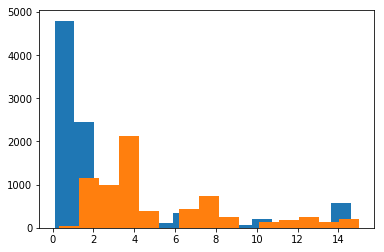

In [83]:
plt.hist([s for t in a for s in t], bins=15);
plt.hist([s for t in c for s in t], bins=15);

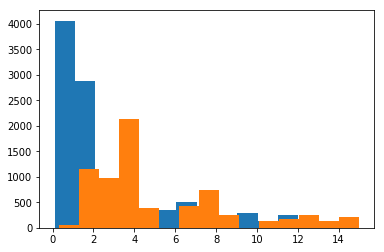

In [84]:
plt.hist([s for t in b for s in t], bins=15);
plt.hist([s for t in c for s in t], bins=15);

In [79]:
beta_a, beta_a_iv = [], []
beta_b, beta_b_iv = [], []
for i in range(len(Zs)):
    Z, X, Y = Zs[i], Xs[i], Ys[i]
    Za = Z[:, 0]
    Zb = Z[:, 1]
    Xa = X[:, 0]
    Xb = X[:, 1]
    Y = Y[:, 2]
#     print(Y.mean(), Xa.mean(), Xb.mean())
    beta_a.append(Y[Xa==1].mean() - Y[Xa==0].mean())
    beta_b.append(Y[Xb==1].mean() - Y[Xb==0].mean())
    beta_a_iv.append(Y[Xa==1].mean() - Y[Za==0].mean())
    beta_b_iv.append(Y[Xb==1].mean() - Y[Zb==0].mean())
    assert Xa[Za==0].sum() == 0
    assert Xb[Zb==0].sum() == 0

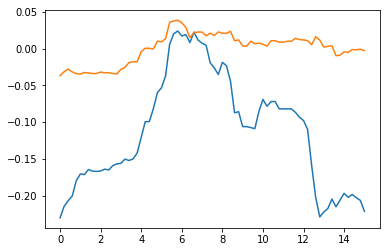

In [80]:
plt.plot(J_AC, beta_a)
plt.plot(J_AC, beta_b)

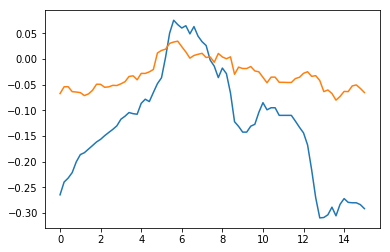

In [81]:
plt.plot(J_AC, beta_a_iv)
plt.plot(J_AC, beta_b_iv)